In [1]:
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

plt.rcParams['image.cmap'] = 'rainbow'

In [2]:
# Get input numpy arrays
inputs = {}
# only a small fraction of data is loaded for exploration purpose
inputs['TT'] = glob.glob('inputdata/output_TT/*job15*.npy')
inputs['QCD120'] = glob.glob('inputdata/output_QCD120/*job0*.npy')
inputs['QCD170'] = glob.glob('inputdata/output_QCD170/*job0*.npy')
inputs['QCD300'] = glob.glob('inputdata/output_QCD300/*job0*.npy')
inputs['QCD470'] = glob.glob('inputdata/output_QCD470/*job0*.npy')

list_params = {}
params = {}
for key, input_files in inputs.items():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print('bad file: {:s}'.format(in_file))
    params[key] = np.concatenate(list_params[key])
# Print out variables in the data
print(params['TT'].dtype)

[('run', '<i4'), ('lumi', '<i4'), ('event', '<i4'), ('met', '<f8'), ('sumet', '<f8'), ('rho', '<f8'), ('pthat', '<f8'), ('mcweight', '<f8'), ('njet_ak7', '<i4'), ('jet_pt_ak7', '<f8'), ('jet_eta_ak7', '<f8'), ('jet_phi_ak7', '<f8'), ('jet_E_ak7', '<f8'), ('jet_msd_ak7', '<f8'), ('jet_area_ak7', '<f8'), ('jet_jes_ak7', '<f8'), ('jet_tau21_ak7', '<f8'), ('jet_isW_ak7', '<i4'), ('jet_ncand_ak7', '<i4'), ('ak7pfcand_pt', '<f8'), ('ak7pfcand_eta', '<f8'), ('ak7pfcand_phi', '<f8'), ('ak7pfcand_id', '<i4'), ('ak7pfcand_charge', '<i4'), ('ak7pfcand_ijet', '<i4')]


In [3]:
# Now let's prepare some jet (ak7) images
df_dict_jet = {}
df_dict_cand = {}

# This is a classification problem where we have two categories.
# Let's call them signal (label as 1) and background (label as 0).
# The signal can be extracted from datasets named "TT", i.e., the object that is a 'W' (jet_isW_ak7==1). 
# Then the background come from datasets named "QCD*". There are 4 of them for the background datasets as 
# in the list_QCD.
list_QCD = ['QCD120','QCD170','QCD300','QCD470']

# For each event, we can have mutiple jets, so the jet columns selections include event-wide variables
# For each jet, we have multiple particle candidates (cand). Each jet has a cone of radius 0.7 and 
# can contain multiple candidates. Therefore we keep candidate level information, i.e., the ak7pfcand_*.
columns_jet = ['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet']
columns_cand = ['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet']

df_dict_jet['TT'] = pd.DataFrame(params['TT'],columns=columns_jet)
# Since each entry contains a pfcand and each event can have multiple pfcand, for event-wise dataframe, 
# there are duplicates. Therefore a drop_duplicates() is necessary.
df_dict_jet['TT'] = df_dict_jet['TT'].drop_duplicates()
df_dict_cand['TT'] = pd.DataFrame(params['TT'],columns=columns_cand)

for QCDbin in list_QCD:
    df_dict_jet[QCDbin] = pd.DataFrame(params[QCDbin],columns=columns_jet)
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].drop_duplicates()
    # Take every 8th jet just to make the things faster
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].iloc[::20, :]
    
    df_dict_cand[QCDbin] = pd.DataFrame(params[QCDbin],columns=columns_cand)

# Create a map of 'QCD' which is a sum of the individual QCD datasets
df_dict_jet['QCD'] = pd.concat([df_dict_jet[x] for x in list_QCD])
df_dict_cand['QCD'] = pd.concat([df_dict_cand[x] for x in list_QCD])

In [4]:
# List the variable name and values stored in the dataframes
df_dict_jet['TT'].iloc[:3]
df_dict_cand['TT'].iloc[:3]

,run,lumi,event,met,sumet,rho,pthat,mcweight,njet_ak7,jet_pt_ak7,jet_eta_ak7,jet_phi_ak7,jet_E_ak7,jet_msd_ak7,jet_area_ak7,jet_jes_ak7,jet_tau21_ak7,jet_isW_ak7,jet_ncand_ak7,ak7pfcand_ijet
0,1,692,68822,0.000003,6.265026e-10,4.456486,0.0,147.332993,2,241.508419,-0.158656,-1.287402,250.423133,35.183504,1.555836,1.022288,0.605893,0,52,0
52,1,692,68822,0.000003,6.265026e-10,4.456486,0.0,147.332993,2,121.746522,-0.450597,1.363096,137.415864,10.171392,1.525916,0.994706,0.709360,0,32,1
84,1,692,68824,33.084671,8.906456e+02,3.563558,0.0,147.332993,1,133.135831,0.863399,2.145941,188.104509,27.989747,1.545863,1.021307,0.837251,0,34,0


,event,jet_pt_ak7,jet_isW_ak7,ak7pfcand_pt,ak7pfcand_eta,ak7pfcand_phi,ak7pfcand_id,ak7pfcand_charge,ak7pfcand_ijet
0,68822,241.508419,0,91.729088,-0.113249,-1.254239,211,1,0
1,68822,241.508419,0,42.692177,-0.114798,-1.242036,22,0,0
2,68822,241.508419,0,17.770281,-0.125908,-1.264955,-211,-1,0


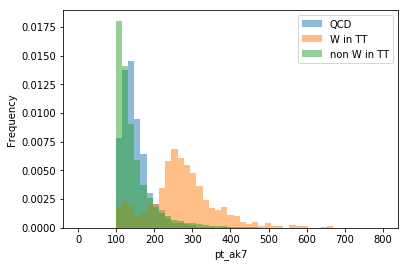

In [5]:
# Plot an important "pt" variable (particle energy) to find its range between signal ('W in TT') and background (QCD).
# Shape difference can be easily found between the signal the background noise and 
# this variable is used as an intensity weight for each 'pixel' when converted to images
_=plt.figure()
_=plt.xlabel('pt_ak7')
bins = np.linspace(0, 800, 50)
_=df_dict_jet['QCD']['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='QCD', weights=df_dict_jet['QCD']['mcweight'],normed=True)
_=df_dict_jet['TT'][df_dict_jet['TT'].jet_isW_ak7==1]['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='W in TT',normed=True)
_=df_dict_jet['TT'][df_dict_jet['TT'].jet_isW_ak7==0]['jet_pt_ak7'].plot.hist(bins, alpha=0.5, label='non W in TT',normed=True)
_=plt.legend(loc='upper right')

In [6]:
# Select interesting events and separate out signal and background, i.e., via 'isW'.
# We can select events for training with specific "jet_pt_ak7" ranges. But here we use all of possible events. 
def selection_cuts(df, ptcuts, isW):
    return df[(df.jet_pt_ak7>ptcuts[0]) & (df.jet_pt_ak7<ptcuts[1]) & (df.jet_isW_ak7==isW)]

# The signals
df_dict_jet['TT'] = selection_cuts(df_dict_jet['TT'], (100., 1000.), 1)
df_dict_cand['TT'] = selection_cuts(df_dict_cand['TT'], (100., 1000.), 1)

# The backgrounds
for QCDbin in list_QCD:
    df_dict_jet[QCDbin] = selection_cuts(df_dict_jet[QCDbin], (100., 1000.), 0)
    df_dict_cand[QCDbin] = selection_cuts(df_dict_cand[QCDbin], (100., 1000.), 0)
    
df_dict_jet['QCD'] = selection_cuts(df_dict_jet['QCD'], (100., 1000.), 0)
df_dict_cand['QCD'] = selection_cuts(df_dict_cand['QCD'], (100.0, 1000.), 0)

print('number of events in TT : {}'.format(len(df_dict_jet['TT'])))
print('number of events in QCD : {}'.format(len(df_dict_jet['QCD'])))
print('number of candidates in TT : {}'.format(len(df_dict_cand['TT'])))
print('number of candidates in QCD : {}'.format(len(df_dict_cand['QCD'])))

number of events in TT : 962
number of events in QCD : 3760
number of candidates in TT : 57705
number of candidates in QCD : 4000000


In [7]:
# Function to fill the object images
def fill_jet_images(df_jet, df_cand, image_dims, rgb_dims):
    nx = image_dims[0]
    ny = image_dims[1]
    xbins = np.linspace(-1.4,1.4,image_dims[0]+1)
    ybins = np.linspace(-1.4,1.4,image_dims[1]+1)
    # Treat the charge of the particle candidate as an additional channel (analogy to the rgb channel in computer vision)
    if rgb_dims == 3:
        # Charges are within values of -1, 0 or 1
        charge_dims = (-1, 0, 1)
    else:
        charge_dims = (-99) 
    list_x = []
    list_y = []
    list_w = []
    njets = 0
    map_jet = {}
    this_jet_images = np.zeros((len(df_jet), image_dims[0], image_dims[1], rgb_dims))
    # Loop over the jet objects
    for ij in range(len(df_jet)):
        njets += 1
        map_jet[njets] = {}
        # Process the rgb channels
        for ic in range(rgb_dims):
            target_charge = charge_dims[ic]
            # Filter out rows with only target_charge. If it's -99, then no filtering.    
            if target_charge != -99:
                df_cand_tmp = df_cand[df_cand['ak7pfcand_charge']==target_charge]
            else:
                df_cand_tmp = df_cand
            # For each of the jet object, using 'ak7pfcand_ijet' to match and select all related particle candidates
            df_cand_ij = df_cand_tmp[(df_cand_tmp['ak7pfcand_ijet'] == df_jet['ak7pfcand_ijet'].iloc[ij]) & (df_cand_tmp['event']==df_jet['event'].iloc[ij])]
            # Normalize the jet image to be the first candidate coordiates
            x = df_cand_ij['ak7pfcand_eta'] - df_cand_ij['ak7pfcand_eta'].iloc[0]
            y = df_cand_ij['ak7pfcand_phi'] - df_cand_ij['ak7pfcand_phi'].iloc[0]
            # The weights (analogy to color channel intensity) are the transverse momentum (pt) of the candidates
            weights = df_cand_ij['ak7pfcand_pt']
            # Accumulate them all (later for plotting)
            x = x.as_matrix()
            y = y.as_matrix()
            weights = weights.as_matrix()            
            list_x.append(x)
            list_y.append(y)
            list_w.append(weights)
            hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
            map_jet[njets]['x'] = x
            map_jet[njets]['y'] = y
            map_jet[njets]['w'] = weights
            for ix in range(nx):
                for iy in range(ny):
                    # Fill the image to a numpy array
                    this_jet_images[ij, ix, iy, ic] = hist[ix, iy]
    return njets, list_x, list_y, list_w, this_jet_images, map_jet

In [8]:
jet_images = {}
jet_maps = {}
# 4D tensor
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is for channels (or rgb, etc.)

image_dims = (30, 30) # (nx, ny)
rgb_dims = 3 # for charge (-1, 0, 1)

nx = image_dims[0]
ny = image_dims[1]
xbins = np.linspace(-1.4,1.4,image_dims[0]+1)
ybins = np.linspace(-1.4,1.4,image_dims[1]+1)

In [9]:
njets_TT, list_x_TT, list_y_TT, list_w_TT, this_jet_images_TT, map_jet_TT = fill_jet_images(df_dict_jet['TT'], df_dict_cand['TT'], image_dims, rgb_dims)
jet_images['TT'] = this_jet_images_TT
jet_maps['TT'] = map_jet_TT

all_x_TT = np.concatenate(list_x_TT)
all_y_TT = np.concatenate(list_y_TT)
all_w_TT = np.concatenate(list_w_TT)
# Average the weights by total number of jet objects
all_w_TT = 1.*all_w_TT/njets_TT

njets_QCD, list_x_QCD, list_y_QCD, list_w_QCD, this_jet_images_QCD, map_jet_QCD = fill_jet_images(df_dict_jet['QCD'], df_dict_cand['QCD'], image_dims, rgb_dims)
jet_images['QCD'] = this_jet_images_QCD
jet_maps['QCD'] = map_jet_QCD
            
all_x_QCD = np.concatenate(list_x_QCD)
all_y_QCD = np.concatenate(list_y_QCD)
all_w_QCD = np.concatenate(list_w_QCD)
# Average the weights by total number of jet objects
all_w_QCD = 1.*all_w_QCD/njets_QCD

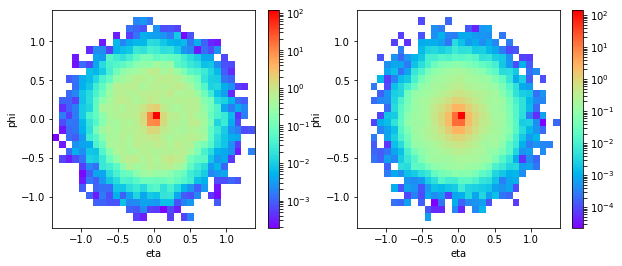

In [10]:
# Make jet image plots for signal ('W in TT') and background ('QCD') categories.
# They are average jet images over all the objects.
# Both images are quite similar but with subtle differences, therefore a deep neural network can potentially explore 
# the underlying information and make a great classifier. 
_=plt.figure(figsize=(10,4))

_=plt.subplot(1,2,1)
_=plt.hist2d(all_x_TT, all_y_TT, weights=all_w_TT, bins=(xbins,ybins), norm=mpl.colors.LogNorm(), label='W in TT')
_=plt.colorbar()
_=plt.xlabel('eta')
_=plt.ylabel('phi')

_=plt.subplot(1,2,2)
_=plt.hist2d(all_x_QCD, all_y_QCD, weights=all_w_QCD, bins=(xbins,ybins), norm=mpl.colors.LogNorm(), label='QCD')
_=plt.colorbar()
_=plt.xlabel('eta')
_=plt.ylabel('phi')
_=plt.show()